In [159]:
print('What\'s up?')

What's up?


# Notebook Imports

In [160]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [161]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [162]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [163]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [164]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [165]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [166]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [167]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path): 
#         // walk function lies inside operating system libraries it is helpful when you need to walk inside the folder contains large no
#            no: of files //
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [168]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [169]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [170]:
df_from_directory(SPAM_1_PATH, 1)

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...
00006.5ab5620d3d7c6c0db76234556a16f6c1,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...
00007.d8521faf753ff9ee989122f6816f87d7,1,Help wanted. We are a 14 year old fortune 500...
00008.dfd941deb10f5eed78b1594b131c9266,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...
00009.027bf6e0b0c4ab34db3ce0ea4bf2edab,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...
00010.445affef4c70feec58f9198cfbc22997,1,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce..."


In [171]:
spam_emails.shape

(1898, 2)

In [172]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [173]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [174]:
data.tail()

,CATEGORY,MESSAGE
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


# Data Cleaning: Checking for Missing Values

In [175]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [176]:
type("")

str

In [177]:
len("")

0

In [178]:
my_var = None

In [179]:
type(my_var)

NoneType

In [180]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [181]:
(data.MESSAGE.str.len() == 0).sum()

3

In [182]:
# Challenge: how would you check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [183]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [184]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [185]:
# data.index.get_loc('.DS_Store')

In [186]:
data[4608:4611]

,CATEGORY,MESSAGE
00210.ca401834d76bbedb98e548160e2ab559,0,I have a strange problem with one user in a sm...
00211.835ec23b746b6aede4e2e15ced421bb4,0,"I just heard from Kevin Patrick Scannell, auth..."
00212.df5211161d938a2547804a50f0a8698f,0,"At 17:34 31/07/02 +0100, Liam Bedford wrote:\n..."


# Remove System File Entries from Dataframe

In [187]:
# data.drop(['cmds', '.DS_Store'], inplace=True)

# data[4608:4611]

In [188]:
data.shape

(5799, 2)

# Add Document IDs to Track Emails in Dataset

In [189]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [190]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [191]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5794,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5795,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5796,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5797,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5798,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


# Save to File using Pandas

In [192]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [193]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [194]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

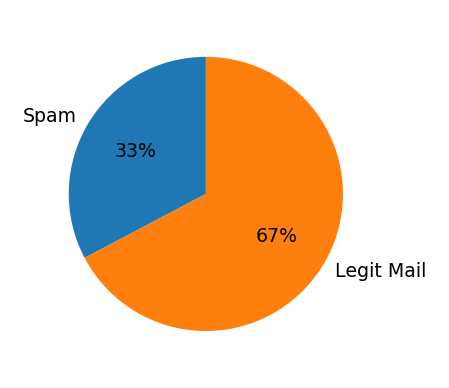

In [195]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%')
plt.show()

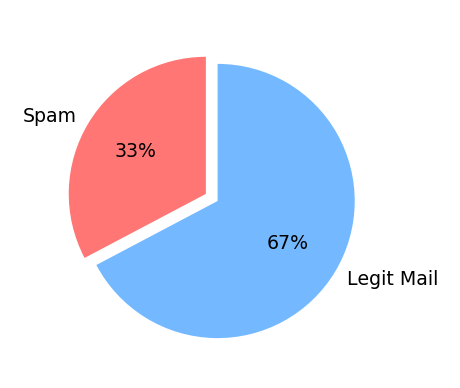

In [196]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

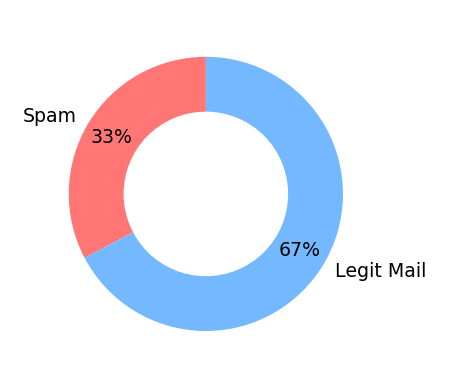

In [197]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

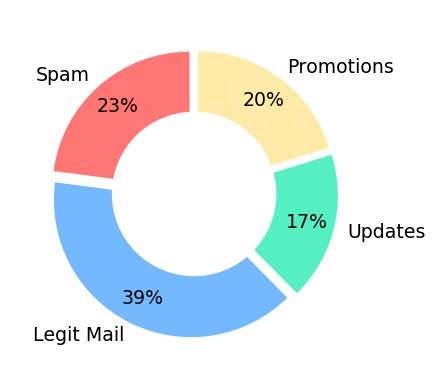

In [198]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [199]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [200]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Nikhilesh
[nltk_data]     Verma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [201]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Nikhilesh
[nltk_data]     Verma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [202]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to C:\Users\Nikhilesh
[nltk_data]     Verma\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to C:\Users\Nikhilesh
[nltk_data]     Verma\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [203]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words 

In [204]:
stop_words = set(stopwords.words('english'))

In [205]:
type(stop_words)

set

In [206]:
if 'this' in stop_words: print('Found it!')

Found it!


In [207]:
# Challenge: print out 'Nope. Not in here' if the word "hello" is not contained in stop_words

In [208]:
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


In [209]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [210]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [211]:
'p'.isalpha()

True

In [212]:
'?'.isalpha()

False

In [213]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
      Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [214]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [215]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Functions for Email Processing

In [216]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [217]:
clean_message(email_body)
len(email_body)


1022

In [218]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [219]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [220]:
data.iat[2, 2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [221]:
data.iloc[5:11]

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,1,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",00010.445affef4c70feec58f9198cfbc22997
10,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e


In [222]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [223]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
len(flat_list)

321

In [224]:
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [225]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

Wall time: 1min 29s


In [226]:
nested_list.tail()

DOC_ID
5794    [http, bizarr, collect, stuf, anim, could, fet...
5795    [care, use, one, also, realli, cute, thing, ja...
5796    [sm, skip, montanaro, write, jeremi, put, anot...
5797    [mark, hammond, like, given, zodb, sound, attr...
5798    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [227]:
data[data.CATEGORY == 1].shape

(1898, 3)

In [228]:
data[data.CATEGORY == 1].tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
1893,1,This is a multi-part message in MIME format.\n...,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1894,1,"Dear Subscriber,\n\n\n\nIf I could show you a ...",01398.8ca7045aae4184d56e8509dc5ad6d979
1895,1,****Mid-Summer Customer Appreciation SALE!****...,01399.2319643317e2c5193d574e40a71809c2
1896,1,ATTN:SIR/MADAN \n\n\n\n ...,01400.b444b69845db2fa0a4693ca04e6ac5c5
1897,1,,cmds


In [229]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which 
# hold onto the indices for the spam and the non-spam emails respectively. 

In [230]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [231]:
doc_ids_ham

Int64Index([1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
            ...
            5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798],
           dtype='int64', name='DOC_ID', length=3901)

### Subsetting a Series with an Index

In [232]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [233]:
type(nested_list)

pandas.core.series.Series

In [234]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [235]:
nested_list_ham.shape

(3901,)

In [236]:
nested_list_ham.tail()

DOC_ID
5794    [http, bizarr, collect, stuf, anim, could, fet...
5795    [care, use, one, also, realli, cute, thing, ja...
5796    [sm, skip, montanaro, write, jeremi, put, anot...
5797    [mark, hammond, like, given, zodb, sound, attr...
5798    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [237]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [238]:
# Challenge: use python list comprehension and then find the total number of 
# words in our cleaned dataset of spam email bodies. Also find the total number of 
# words in normal emails in the dataset. Then find the 10 most common words used in 
# spam. Also, find the 10 most common words used in non-spam messages. 

In [239]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20755

In [240]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [241]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13284

In [242]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

# Creating a Word Cloud

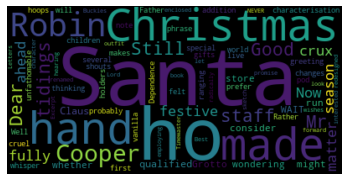

In [243]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [244]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [245]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [246]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [247]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

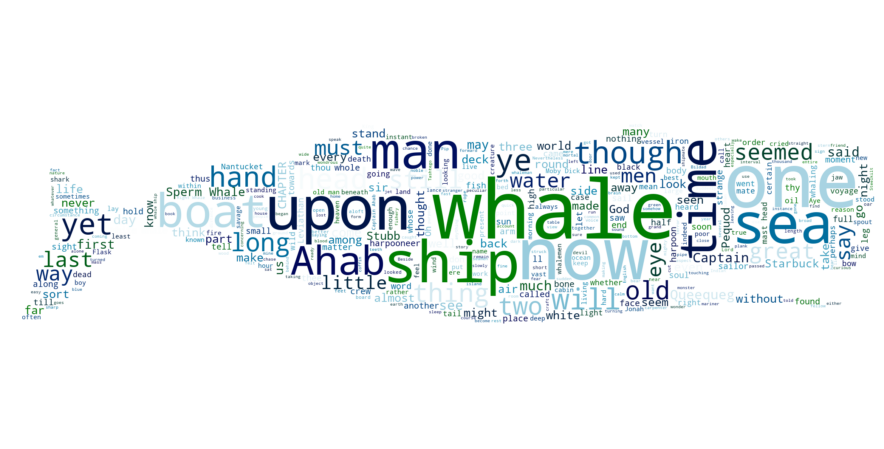

In [248]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [249]:
rgb_array.shape

(1024, 2048, 3)

In [250]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [251]:
rgb_array[500, 1000]

array([0, 0, 0], dtype=uint8)

In [252]:
# Challenge: use the skull image in the lesson resources to create a word cloud
# for Shakespeare's play Hamlet

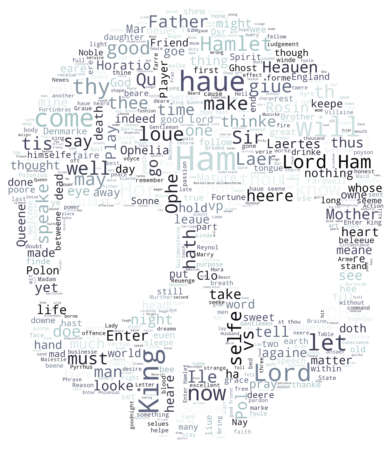

In [253]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      colormap='bone', max_words=600)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

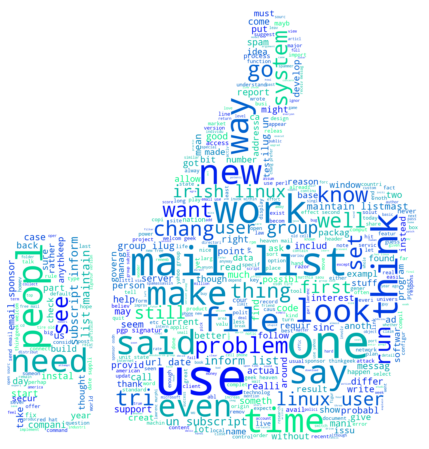

In [254]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [255]:
# Challenge: Look at the word cloud documentation. Use the custom font included in the 
# lesson resources instead of the default font and create a word cloud of the spammy words

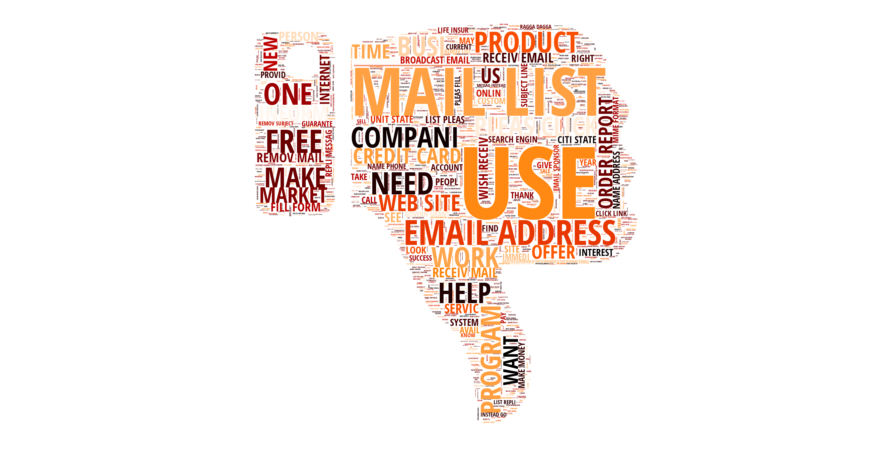

In [256]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [257]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [258]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27305


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [259]:
# Challenge: Create subset of the series called 'frequent_words' that only contains
# the most common 2,500 words out of the total. Print out the top 10 words

In [260]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [261]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [262]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [263]:
# Challenge: Write a line of code that checks if a particular word is part 
# of the vocabulary. Your code should return True if the word is among the 
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [264]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [265]:
'brew' in set(vocab.VOCAB_WORD) # better way

False

# Exercise: Find the Email with the Most Number of Words

In [266]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# Hint: use the len() function and practice list comprehension

In [267]:
# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [268]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))


Nr words in the longest email: 7671


In [269]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))


Email position in the list (and the data dataframe) 5778


In [270]:
stemmed_nested_list[np.argmax(clean_email_lengths)]


['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [271]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']


'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [272]:
type(stemmed_nested_list)

pandas.core.series.Series

In [273]:
type(stemmed_nested_list.tolist())

list

In [274]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [275]:
word_columns_df.shape

(5799, 7671)

### Splitting the Data into a Training and Testing Dataset

In [276]:
# Challenge: Can you split the data into a training and testing set? Set the test size at 30%. 
# The training data should include 4057 emails. Use a seed value of 42 to shuffle the data. 
# What should the target values be? 

In [277]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [278]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4059
Fraction of training set 0.6999482669425763


In [279]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4100,url,http,date,suppli,key,encod,photon,light,sent,kilometr,...,None,None,None,None,None,None,None,None,None,None
5233,dave,long,write,also,strike,long,livestock,genet,engin,dumber,...,None,None,None,None,None,None,None,None,None,None
5072,thu,jul,matthia,saou,wrote,upon,time,matthia,wrote,subject,...,None,None,None,None,None,None,None,None,None,None
1293,creditfix,access,clear,bad,credit,onlin,directli,convieni,watch,credit,...,None,None,None,None,None,None,None,None,None,None
4357,us,lister,recognis,damian,lewi,winter,band,brother,annoy,one,...,None,None,None,None,None,None,None,None,None,None


In [280]:
y_train.head()


DOC_ID
4100    0
5233    0
5072    0
1293    1
4357    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [281]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [282]:
word_index.get_loc('thu')

396

In [283]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [284]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 7min 8s


In [285]:
sparse_train_df[:5]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4100,0,1,109
1,4100,0,1,0
2,4100,0,1,76
3,4100,0,1,341
4,4100,0,1,383


In [286]:
sparse_train_df.shape

(449049, 4)

In [287]:
sparse_train_df[-5:]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
449044,860,1,1,196
449045,860,1,1,573
449046,860,1,1,18
449047,860,1,1,222
449048,860,1,1,0


### Combine Occurrences with the Pandas groupby() Method

In [288]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [289]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [290]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [291]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [292]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
263454,5798,2046,0,2
263455,5798,2059,0,1
263456,5798,2289,0,1
263457,5798,2352,0,1
263458,5798,2413,0,1


In [293]:
vocab.at[1923, 'VOCAB_WORD']

'gmt'

In [294]:
data.MESSAGE[5795]

'> >-- be careful when using this one.) Also, that really cute thing \n\nthat\n\n> >Japanese AV girls do of leaving their panties on one leg while \n\nmaking love\n\n\n\nDare I ask what a Japanese "AV girl" is? \n\ntimh\n\n\n\n\n\n------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/46VHAA/7gSolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nTo unsubscribe from this group, send an email to:\n\nforteana-unsubscribe@egroups.com\n\n\n\n \n\n\n\nYour use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/ \n\n\n\n\n\n\n'

In [295]:
train_grouped.shape

(263459, 4)

### Save Training Data as .txt File

In [296]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [297]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Challenge

Can you create a sparse matrix for the test data. Group the occurrences of the same word in the same email. Then save the data as a .txt file. 

In [298]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4925,thu,jul,chad,norwood,wrote,steven,champeon,wrote,chad,progress,...,None,None,None,None,None,None,None,None,None,None
1103,webcredit,thank,email,address,obtain,ase,list,refer,wish,unsubscrib,...,None,None,None,None,None,None,None,None,None,None
812,hello,jm,growth,hormon,therapi,lose,weight,build,lean,muscl,...,None,None,None,None,None,None,None,None,None,None
1632,applic,grant,rememb,type,grant,never,need,repay,time,limit,...,None,None,None,None,None,None,None,None,None,None
1128,hey,like,tri,everyth,lose,weight,know,feel,special,diet,...,None,None,None,None,None,None,None,None,None,None


In [299]:
y_test.head()

DOC_ID
4925    0
1103    1
812     1
1632    1
1128    1
Name: CATEGORY, dtype: int64

In [300]:
X_test.shape

(1740, 7671)

In [301]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 4min 12s


In [302]:
sparse_test_df.shape

(185084, 4)

In [303]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [304]:
test_grouped.shape

(112474, 4)

In [305]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [306]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [307]:
len(test_doc_ids)

1725

In [308]:
len(X_test)

1740

In [309]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

{134,
 179,
 240,
 274,
 298,
 339,
 439,
 471,
 879,
 925,
 1101,
 1235,
 1361,
 1545,
 1897}

In [310]:
data.MESSAGE[14]

'<HTML><HEAD><TITLE>Lowest Rate Services</TITLE>\n\n<META http-equiv=3DContent-Type content=3D"text/html; charset=3Dwindows-12=\n\n52">\n\n<META content=3D"MSHTML 5.50.4134.600" name=3DGENERATOR></HEAD>\n\n<BODY vLink=3D#c0c0c0 link=3D#c0c0c0 bgColor=3D#000033 leftMargin=3D0><FON=\n\nT \n\nface=3Darial,helvetica>\n\n<P>\n\n<CENTER>\n\n<TABLE width=3D600 border=3D0>\n\n  <TBODY>\n\n  <TR>\n\n    <TD align=3Dmiddle><B><FONT color=3D#999999 size=3D6>Conferencing Made=\n\n Easy</FONT><BR>\n\n<FONT color=3D#999999 size=3D5>Only <U>18 Cents</U> Per Minute!</B></FONT>=\n\n</TD></TR></TBODY></TABLE>\n\n<P><FONT color=3D#ff0000 size=3D5><B>(Including Long Distance!)</B></FONT>=\n\n \n\n<P>\n\n<TABLE width=3D350 border=3D0>\n\n  <TBODY>\n\n  <TR>\n\n    <TD><FONT color=3D#999999 size=3D3><B>\n\n      <LI>No setup fees \n\n      <LI>No contracts or monthly fees \n\n      <LI>Call anytime, from anywhere, to anywhere \n\n      <LI>Connects up to 100 Participants \n\n      <LI>Simplicity in set up a

In [311]:
data.loc[14]

CATEGORY                                                     1
MESSAGE      <HTML><HEAD><TITLE>Lowest Rate Services</TITLE...
FILE_NAME               00015.048434ab64c86cf890eda1326a5643f5
Name: 14, dtype: object

In [312]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

['lowest',
 'rate',
 'servic',
 'conferenc',
 'easi',
 'cent',
 'per',
 'minut',
 'includ',
 'long',
 'distanc',
 'setup',
 'fee',
 'contract',
 'monthli',
 'fee',
 'call',
 'anytim',
 'anywher',
 'anywher',
 'connect',
 'particip',
 'simplic',
 'set',
 'administr',
 'oper',
 'help',
 'avail',
 'highest',
 'qualiti',
 'servic',
 'lowest',
 'rate',
 'industri',
 'fill',
 'form',
 'low',
 'find',
 'lower',
 'phone',
 'bill',
 'everi',
 'requir',
 'input',
 'web',
 'address',
 'compani',
 'busi',
 'home',
 'phone',
 'email',
 'type',
 'busi',
 'remov',
 'distribut',
 'list',
 'pleas',
 'click']

In [313]:
data.MESSAGE[1096]

'<HTML><BR><FONT  COLOR=3D"#ff00ff" BACK=3D"#ffffff" style=3D"BACKGROUND-COL=\n\nOR: #ffffff" SIZE=3D3 PTSIZE=3D12><center>x=3D=3Dx*x=3D=3Dxx=3D=3Dx*x=3D=3D=\n\nxx=3D=3Dx*x=3D=3Dxx=3D=3Dx*x=3D=3Dxx=3D=3Dx*x=3D=3Dxx=3D=3Dx*x=3D=3Dx</cen=\n\nter><br><br><i><b>Absolutely Awesome!!</b></i><br><br><!--#rotate> <b> Ins=\n\ntantly </FONT><FONT  COLOR=3D"#ff0000" BACK=3D"#ff80ff" style=3D"BACKGROUN=\n\nD-COLOR: #ff80ff" SIZE=3D3 PTSIZE=3D12 FAMILY=3D"SANSSERIF" FACE=3D"Arial"=\n\n LANG=3D"0"> &nbsp;S e x u a l l y  Attract</FONT></FONT><FONT  COLOR=3D"#=\n\nff00ff" BACK=3D"#ffffff" style=3D"BACKGROUND-COLOR: #ffffff" SIZE=3D3 PTSI=\n\nZE=3D12 FAMILY=3D"SANSSERIF" FACE=3D"Arial" LANG=3D"0"> with nature\'s secr=\n\net weapon..." P  h  e  r  o  m  o n  e  s"<BR>\n\n<BR><BR>\n\n"I n v i s i b l e   a n d   u n d e t e c t a b l e" , when unknowingly i=\n\nnhaled, Pheromone Concentrate  unblocks all restraints and releases the ra=\n\nw  animal s e x drive!<BR>\n\n<BR> <BR> \n\nThis is the strongest

In [314]:
clean_msg_no_html(data.at[1096, 'MESSAGE'])

['awesom',
 'rotat',
 'tantli',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'natur',
 'et',
 'weapon',
 'p',
 'h',
 'e',
 'r',
 'n',
 'e',
 'n',
 'v',
 'b',
 'l',
 'e',
 'n',
 'u',
 'n',
 'e',
 'e',
 'c',
 'b',
 'l',
 'e',
 'unknowingli',
 'nhale',
 'pheromon',
 'concentr',
 'unblock',
 'restraint',
 'releas',
 'w',
 'anim',
 'e',
 'x',
 'drive',
 'strongest',
 'concentr',
 'human',
 'allow',
 'law',
 'essenti',
 'oil',
 'base',
 'avail',
 'formula',
 'men',
 'women',
 'click',
 'attract',
 'e',
 'mail',
 'list',
 'pleas',
 'email',
 'us',
 'p',
 'rand',
 'sspltm',
 'pheromon',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'women',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'men',
 'attract',
 'men',
 'ttract',
 'women',
 'men',
 'instantli',
 'attract',
 'women',
 'men',
 'becom',
 'fast',
 'gain',
 'sexual',
 'advantag',
 'power',
 'power',
 'becom',
 'desir']

In [315]:
clean_message(data.at[1096, 'MESSAGE'])

['html',
 'br',
 'font',
 'ffffff',
 'ffffff',
 'center',
 'ter',
 'br',
 'br',
 'b',
 'absolut',
 'awesom',
 'br',
 'br',
 'rotat',
 'b',
 'tantli',
 'font',
 'sansserif',
 'arial',
 'nbsp',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'natur',
 'et',
 'weapon',
 'p',
 'h',
 'e',
 'r',
 'n',
 'e',
 'br',
 'br',
 'br',
 'n',
 'v',
 'b',
 'l',
 'e',
 'n',
 'u',
 'n',
 'e',
 'e',
 'c',
 'b',
 'l',
 'e',
 'unknowingli',
 'nhale',
 'pheromon',
 'concentr',
 'unblock',
 'restraint',
 'releas',
 'w',
 'anim',
 'e',
 'x',
 'drive',
 'br',
 'br',
 'br',
 'strongest',
 'concentr',
 'font',
 'sansserif',
 'arial',
 'human',
 'pheromon',
 'font',
 'ffffff',
 'ff',
 'sansserif',
 'arial',
 'allow',
 'law',
 'essenti',
 'oil',
 'br',
 'br',
 'br',
 'avail',
 'formula',
 'men',
 'br',
 'br',
 'br',
 'br',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'http',
 'click',
 'attract',
 'br',
 'br',
 'br',
 'br',
 'br',
 'br',
 'br',
 'font',
